<a href="https://colab.research.google.com/github/Byeon-MJ/Computer_Vision_Project/blob/main/Face_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Alignment
1. 해상도가 큰 이미지 다운
2. 이미지 속 얼굴이 정면을 바라보게 회전
3. 이미지에서 얼굴 영역만 모두 같은 사이즈로 저장

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import dlib
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# Eyes landmark 정의
RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
EYES = list(range(36, 48))

In [ ]:
# 학습된 dlib 모델 로드
predictor_file = '/content/gdrive/MyDrive/CV/Face Landmark/shape_predictor_68_face_landmarks.dat'

# 원본 이미지 파일
image_file = '/content/gdrive/MyDrive/CV/Face Landmark/face3.jpg'

# output 이미지 해상도
OUTPUT_SIZE = (300, 300)

In [ ]:
# 얼굴을 감지하는 detector 정의
detector = dlib.get_frontal_face_detector()

# facial landmark를 찾아주는 predictor 정의
predictor = dlib.shape_predictor(predictor_file)

# 원본 이미지를 읽어옴
image = cv2.imread(image_file)
# 원본 이미지 copy
image_origin = image.copy()

(image_height, image_width) = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detecor 에 의해 얼굴 감지
rects = detector(gray, 1)

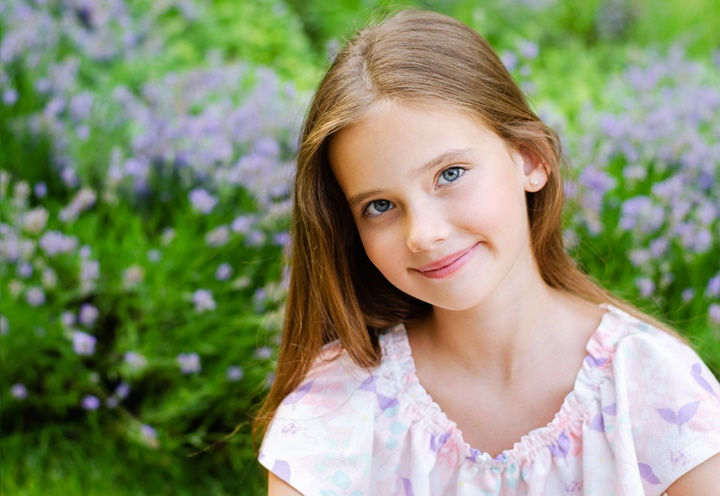

In [ ]:
cv2_imshow(image)

In [ ]:
# rect의 x, y, w, h 구하기
def getFaceDimension(rect):
    return (rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top())

In [ ]:
# Crop 할 좌표 구하기
def getCropDimension(rect, center):
    width = (rect.right() - rect.left())
    half_width = width // 2
    (centerX, centerY) = center
    startX = centerX - half_width
    endX = centerX + half_width
    startY = rect.top()
    endY = rect.bottom()
    return (startX, endX, startY, endY)

= = = = face landmark image = = = =



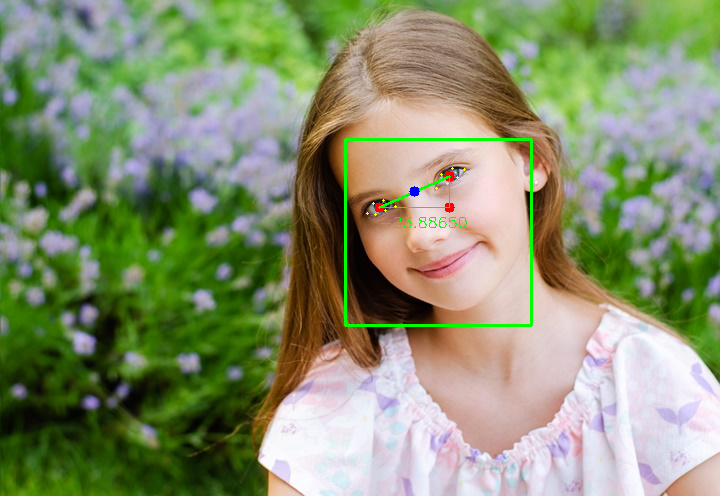

(414, 191)
<class 'int'> <class 'int'>

= = = = rotated image = = = =



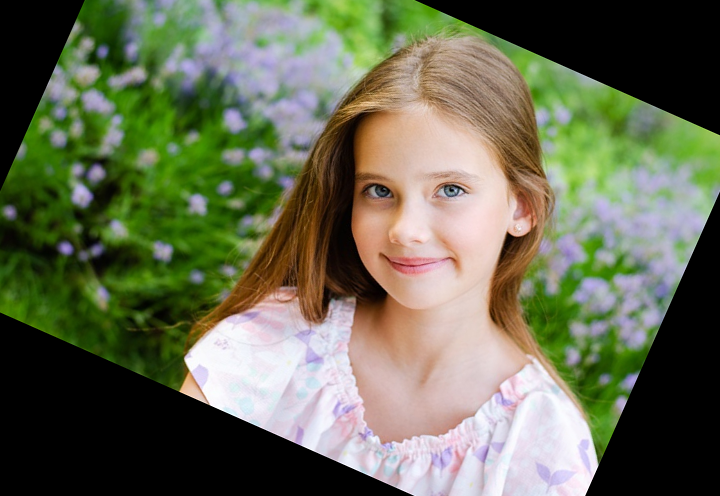


= = = = croped and resized image = = = =



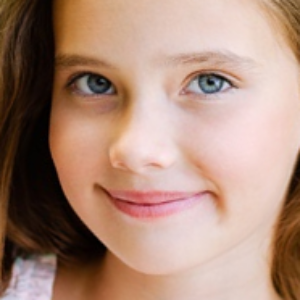

In [ ]:
for (i, rect) in enumerate(rects):
    (x, y, w, h) = getFaceDimension(rect)
        # 이미지에 boxing
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # predictor에 의해 감지된 landmark point를 x, y 좌표로 계산
    points = np.matrix([[p.x, p.y] for p in predictor(gray, rect).parts()])
    show_parts = points[EYES]

    # 오른쪽 눈의 중앙값 계산
    right_eye_center = np.mean(points[RIGHT_EYE], axis = 0).astype('int')
    # print(right_eye_center)
    # 왼쪽 눈의 중앙값 계산
    left_eye_center = np.mean(points[LEFT_EYE], axis = 0).astype('int')
    # print(right_eye_center)



    # 오른쪽 눈의 중앙에 점 찍기
    cv2.circle(image, (right_eye_center[0, 0], right_eye_center[0, 1]), 5, (0, 0, 255), -1)
    # 왼쪽 눈의 중앙에 점 찍기
    cv2.circle(image, (left_eye_center[0, 0], left_eye_center[0, 1]), 5, (0, 0, 255), -1)

    # 왼쪽 눈의 x좌표와 오른쪽 눈의 y좌표에 점 찍기
    cv2.circle(image, (left_eye_center[0, 0], right_eye_center[0, 1]), 5, (0, 0, 255), -1)

    # 오른쪽 눈의 중앙점과 왼쪽 눈의 중앙점 사이에 선 그리기
    cv2.line(image, (right_eye_center[0, 0], right_eye_center[0, 1]),
             (left_eye_center[0, 0], left_eye_center[0, 1]), (0, 255, 0), 2)
    
    # 오른쪽 눈의 중앙점과 왼쪽 눈의 x좌표와 오른쪽 눈의 y좌표 사이에 선 그리기
    cv2.line(image, (right_eye_center[0, 0], right_eye_center[0, 1]), (left_eye_center[0, 0], right_eye_center[0, 1]), (0, 255, 0), 1)

    # 왼쪽 눈의 중앙점과 왼쪽 눈의 x좌표와 오른쪽 눈의 y좌표 사이에 선 그리기
    cv2.line(image, (left_eye_center[0, 0], right_eye_center[0, 1]), 
             (left_eye_center[0, 0], left_eye_center[0, 1]), (0, 255, 0), 1)
    


    eye_delta_x = right_eye_center[0, 0] - left_eye_center[0, 0]
    eye_delta_y = right_eye_center[0, 1] - left_eye_center[0, 1]
    degree = np.degrees(np.arctan2(eye_delta_y, eye_delta_x)) - 180 # arctan2 로 조정 각도 계산

    # 눈 사이의 간격을 Euclidean Distance로 계산(실제 간격)
    eye_distance = np.sqrt((eye_delta_x ** 2) + (eye_delta_y ** 2))

    # alignment 된 눈사이의 간격(조정 거리)
    aligned_eye_distance = left_eye_center[0, 0] - right_eye_center[0, 0]
    
    # 조정된 거리의 스케일
    scale = aligned_eye_distance / eye_distance 

    # # 두 눈의 중앙점 간의 중앙점을 다시 계산
    # eyes_center = ((left_eye_center[0, 0] + right_eye_center[0, 0]) // 2,
    #                (left_eye_center[0, 1] + right_eye_center[0, 1]) // 2)
    # 두 눈의 중앙점 간의 중앙점을 다시 계산
    eyes_center = (int((left_eye_center[0, 0] + right_eye_center[0, 0]) // 2),
                   int((left_eye_center[0, 1] + right_eye_center[0, 1]) // 2))
    
    # 두 눈의 중앙점 간의 중앙점에 점 찍기
    cv2.circle(image, eyes_center, 5, (255, 0, 0), -1)

    # 조정 각도 출력
    cv2.putText(image, '{:.5f}'.format(degree), (right_eye_center[0, 0], right_eye_center[0, 1] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    for (i, point) in enumerate(show_parts):
        x = point[0, 0]
        y = point[0, 1]

        # 눈 위치에 landmark point 그리기
        cv2.circle(image, (x, y), 1, (0, 255, 255), -1)

    print('= = = = face landmark image = = = =\n')
    cv2_imshow(image)

    print(eyes_center)
    print(type(eyes_center[0]), type(eyes_center[1]))
                        # 이미지의 센터, 각도(+:반시계, -:시계), 스케일(확대/축소)
    rotate = cv2.getRotationMatrix2D(eyes_center, degree, scale)

    rotated = cv2.warpAffine(image_origin, rotate, (image_width, image_height), 
                             flags = cv2.INTER_CUBIC)
    
    print('\n= = = = rotated image = = = =\n')
    cv2_imshow(rotated)
    
    # rect에서 Crop 할 이미지 좌표값 구해오기
    (startX, endX, startY, endY) = getCropDimension(rect, eyes_center)
    
    # 회전된 이미지에서 Crop 될 이미지 구하기
    croped = rotated[startY:endY, startX:endX]

    # Crop된 이미지를 Output해상도에 맞게 resizing
    output = cv2.resize(croped, OUTPUT_SIZE)

    print('\n= = = = croped and resized image = = = =\n')
    cv2_imshow(output)

이미지를 face alignment 하는 과정을 거쳐서 얼굴의 특성(encoding) 값과 특정한 인물의 이름을 매칭해 dictionary 타입으로 저장하는 파일('encodings.pickle')로 만들면 face_recognition 패키지를 이용한 Detection 정확도를 높일 수 있다.